In [2]:
import autograd.numpy as np 
from autograd import grad, elementwise_grad, jacobian, make_jvp 
from autograd.scipy.special import erf

import GPy
from GPy.kern import Kern
from GPy.core.parameterization.param import Param

import matplotlib.pyplot as plt

## Vectorised Kernel And Gradients

In [25]:
def k_ou(tmat1, tmat2, bvec, d1s=None, d2s=None):
    d = bvec.shape[0]
    
    n1 = tmat1[list(tmat1.keys())[0]].shape[0]
    n2 = tmat2[list(tmat2.keys())[0]].shape[0]
     
    
    if d1s is None:
        d1s = range(bvec.shape[0])
    if d2s is None:
        d2s = range(bvec.shape[0])
        
    d1_ = len(d1s)
    d2_ = len(d2s)
    
    kf = np.zeros((d1_ * n1, d2_ * n2))
    
    for i, d1 in enumerate(d1s):
        for j, d2 in enumerate(d2s):
            if d1 == d2:
                t1 = tmat1[d1]
                t2 = tmat2[d2]
                
                t1Minust2 = t1[...,None] - t2
                kf[i * n1 : (i+1) * n1, j * n2 : (j+1) * n2] = np.exp(- bvec[d1] * np.abs(t1Minust2 ) )  / (2 * bvec[d1])

    return kf


def k_ou_grad(tmat1, tmat2, bvec, d1s=None, d2s=None):

    d = bvec.shape[0]
    
    n1 = tmat1[list(tmat1.keys())[0]].shape[0]
    n2 = tmat2[list(tmat2.keys())[0]].shape[0]
     
    
    if d1s is None:
        d1s = range(bvec.shape[0])
    if d2s is None:
        d2s = range(bvec.shape[0])
        
    d1_ = len(d1s)
    d2_ = len(d2s)
    
    kf = np.zeros((d1_ * n1, d2_ * n2, bvec.shape[0]))
    
    for i, d1 in enumerate(d1s):
        for j, d2 in enumerate(d2s):
            if d1 == d2:
                t1 = tmat1[d1]
                t2 = tmat2[d2]
                
                t1Minust2 = t1[...,None] - t2
                ou =  np.exp(- bvec[d1] * np.abs(t1Minust2 ) ) / (2 * bvec[d1])
                
                kf[i * n1 : (i+1) * n1, j * n2 : (j+1) * n2, d1] = -(1.0 / bvec[d1]  +   np.abs(t1Minust2 ) ) * ou

    return kf

In [68]:
def diag_k_ou(tmat, bvec, d1s):
    
    d = len(d1s)
    
    n = tmat[list(tmat.keys())[0]].shape[0]
#     print(d,n)
    out = 0.5 / bvec[d1s].repeat(n)[..., None]
    print(out.shape)
    return out

## Kernel Class

In [69]:
class OU_block(GPy.kern.Kern):
    
    def __init__(self,input_dim=2, bvec=np.array([1.0]),
                 active_dims=(0,1)):
    
        super(OU_block, self).__init__(input_dim, active_dims, 'OU_block')
        
        self.bvec = Param('bvec', bvec)
        self.link_parameters(self.bvec)
        self.show = False
    
    @staticmethod
    def preprocess(X):
        d1s = np.unique(X[:,1]).astype(int)
        X_ = {} 
        for d1 in d1s:
            X_[d1] =  X[X[:,1] == d1][:,0] 
        return d1s, X_
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        d1s, X_ = self.preprocess(X)
        d2s, X2_ = self.preprocess(X2)
            
        k =  k_ou(X_, X2_, self.bvec, d1s, d2s)
  
        return k 

    
    def Kdiag(self, X):
        d1s, X_ = self.preprocess(X)

        return diag_k_ou(X_, self.bvec, d1s=d1s).flatten()
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        d1s, X_ = self.preprocess(X)
        d2s, X2_ = self.preprocess(X2)

        db = k_ou_grad(X_, X2_, self.bvec, d1s, d2s)

        self.bvec.gradient = np.sum(db * dL_dK[..., None], axis=(0,1))

## GPy Experiments

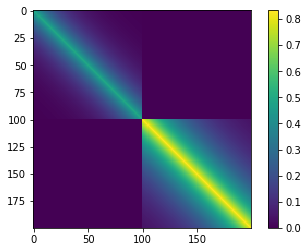

In [34]:
t1 = np.linspace(0,5, 100).reshape(-1,1)  
# t1 = np.linspace(0,20, 30).reshape(-1,1)

bvec = np.array([1.0, 0.6])

# create simple GP Model
kernel_ou = OU_block(input_dim=2, bvec=bvec)
t_,y_, output_index = GPy.util.multioutput.build_XY([t1, t1], [t1, t1])


kk4 = kernel_ou.K(t_, t_)
plt.imshow(kk4)
plt.colorbar()

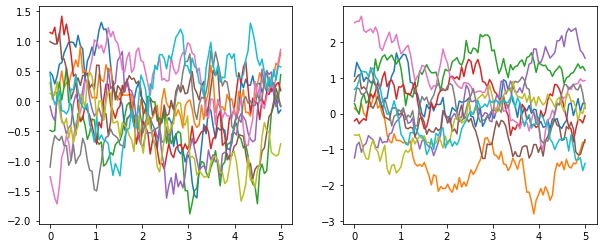

In [42]:
guys1 = np.random.multivariate_normal(np.zeros(int(kk4.shape[0] * 0.5)), kk4[0:100, 0:100], 10)
guys2 = np.random.multivariate_normal(np.zeros(int(kk4.shape[0] * 0.5)), kk4[100:, 100:], 10)

fig , axs = plt.subplots(1,2, figsize=(10,4))

[axs[0].plot(t1, guy) for guy in guys1];
[axs[1].plot(t1, guy) for guy in guys2];

In [49]:
# y1.shape

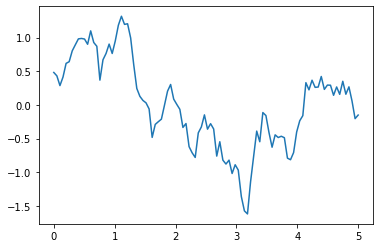

done init


(200, 1)
(200, 1)
(200, 1)
(200, 1)


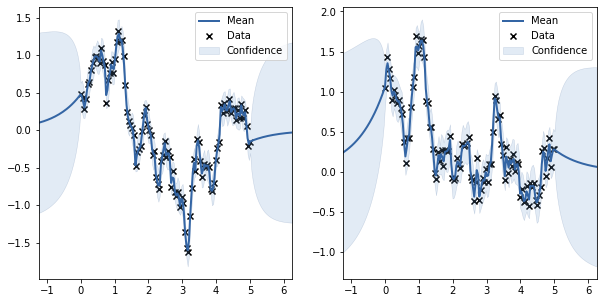

In [70]:
t1 = t1
# t1 = np.linspace(0,20, 30).reshape(-1,1)

bvec = np.array([1.0, 0.6])

# create simple GP Model
kernel_lfm1 = OU_block(input_dim=2, bvec=bvec)

y1 = guys1[0][..., None]
y2 = guys2[0][..., None]
plt.plot(t1, y1)
plt.show()
# bbb

m = GPy.models.GPCoregionalizedRegression(X_list=[t1,t1], Y_list=[y1, y2], kernel=kernel_lfm1)
print("done init")

optimize = True
plot = True
if optimize:
    m.optimize('bfgs', max_iters=200, messages=True)
if plot:
    slices = GPy.util.multioutput.get_slices([t1,t1])
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    m.plot(fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0},ax=axs[0])
    m.plot(fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1}, ax=axs[1])
    plt.show()